# Safety Analysis 

## Data Sources

For this analysis, I will use data from the Pittsburgh Police Incident Blotter archive and neighborhood population data. Also, we need the popluation data for each neighborhood to calculate the crime rate per capita.

1. **Blotter Data (UCR Coded)**
   - Contains data updated since January 1, 2016

2. **total Population Data**
    - Includes population data of each neighborhood


## Step 1: Upload two datasets

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

safety_data = pd.read_csv('blotter-data.csv', index_col='INCIDENTNEIGHBORHOOD')
population_data = pd.read_csv('total-population.csv', index_col='Neighborhood', usecols=['Neighborhood', 'Estimate; Total'])
print(safety_data.head(5))
print(population_data.head(5))




                             _id       PK         CCR  HIERARCHY  \
INCIDENTNEIGHBORHOOD                                               
North Shore                    1  2802309  16000001.0         10   
Upper Lawrenceville            2  2803174  16004547.0         11   
Northview Heights              3  2801809  16000367.0          4   
Golden Triangle/Civic Arena    4  2802315  16000035.0         10   
Northview Heights              5  2802312  16000024.0          4   

                                    INCIDENTTIME  \
INCIDENTNEIGHBORHOOD                               
North Shore                  2016-01-01T00:00:00   
Upper Lawrenceville          2016-01-01T00:01:00   
Northview Heights            2016-01-01T00:10:00   
Golden Triangle/Civic Arena  2016-01-01T00:15:00   
Northview Heights            2016-01-01T00:16:00   

                                                          INCIDENTLOCATION  \
INCIDENTNEIGHBORHOOD                                                         
No

## Step 2: count the number of crime in each neighborhood

In [29]:
crime_counts = safety_data.groupby('INCIDENTNEIGHBORHOOD').size()
crime_counts_df = crime_counts.reset_index()
crime_counts_df.columns = ['INCIDENTNEIGHBORHOOD', 'crime_count']
print(crime_counts_df)

   INCIDENTNEIGHBORHOOD  crime_count
0      Allegheny Center         3614
1        Allegheny West         1094
2             Allentown         5273
3             Arlington         2166
4     Arlington Heights          573
..                  ...          ...
93  Upper Lawrenceville         1670
94             West End         1290
95         West Oakland         2014
96             Westwood         1650
97              Windgap          886

[98 rows x 2 columns]


## Step 3: Cleaning data 

deal with the incorrect neighborhood name and missing data


In [30]:
population_data = population_data.rename(columns={'Neighborhood': 'INCIDENTNEIGHBORHOOD', 'Estimate; Total': 'population'})
missing_in_population = set(crime_counts_df['INCIDENTNEIGHBORHOOD']) - set(population_data.index)
missing_in_crime = set(population_data.index) - set(crime_counts_df['INCIDENTNEIGHBORHOOD'])
## Correct neighborhood names to match population data
crime_counts_df['INCIDENTNEIGHBORHOOD'] = crime_counts_df['INCIDENTNEIGHBORHOOD'].replace('Central Northside', 'Central North Side')
crime_counts_df['INCIDENTNEIGHBORHOOD'] = crime_counts_df['INCIDENTNEIGHBORHOOD'].replace('Troy Hill-Herrs Island', 'Troy Hill')
crime_counts_df['INCIDENTNEIGHBORHOOD'] = crime_counts_df['INCIDENTNEIGHBORHOOD'].replace('Mt. Oliver Neighborhood', 'Mount Oliver')
## Remove entries that do not correspond to specific neighborhoods
crime_counts_df = crime_counts_df[~crime_counts_df['INCIDENTNEIGHBORHOOD'].isin(['Golden Triangle/Civic Arena','Outside City','Outside County','Outside State'])]
## check for missing neighborhoods
print(f"\nexist in crime data but not in population data ({len(missing_in_population)}个):")
for n in sorted(missing_in_population):
    print(f"  - {n}")

print(f"\nexist in population data but not in crime data ({len(missing_in_crime)}个):")
for n in sorted(missing_in_crime):
    print(f"  - {n}")




exist in crime data but not in population data (7个):
  - Central Northside
  - Golden Triangle/Civic Arena
  - Mt. Oliver Neighborhood
  - Outside City
  - Outside County
  - Outside State
  - Troy Hill-Herrs Island

exist in population data but not in crime data (0个):


## Step4: calculate the crime rate per capita 

In [31]:
merged_data = pd.merge(
    crime_counts_df,
    population_data,
    left_on='INCIDENTNEIGHBORHOOD',
    right_index=True,
    how='inner'
)

print("merged data:\n", merged_data.head())


merged_data['crime_rate_per_100k'] = (merged_data['crime_count'] / merged_data['population']) * 100000

# sort by crime rate per 100k
sorted_data = merged_data.sort_values('crime_rate_per_100k')

# the safest 10 neighborhoods (by crime rate per 100k)
print("\nthe safest 10 neighborhoods (by crime rate per 100k):")
print(sorted_data[['INCIDENTNEIGHBORHOOD', 'crime_count', 'population', 'crime_rate_per_100k']].head(10))



merged data:
   INCIDENTNEIGHBORHOOD  crime_count  population
0     Allegheny Center         3614      1411.0
1       Allegheny West         1094       343.0
2            Allentown         5273      2558.0
3            Arlington         2166      1852.0
4    Arlington Heights          573       272.0

the safest 10 neighborhoods (by crime rate per 100k):
   INCIDENTNEIGHBORHOOD  crime_count  population  crime_rate_per_100k
56      Mt. Oliver Boro          101      3399.0          2971.462195
91            Troy Hill          252      2283.0         11038.107753
57         Mount Oliver          117       598.0         19565.217391
19   Central North Side          786      2892.0         27178.423237
88       Swisshelm Park          443      1345.0         32936.802974
82  Squirrel Hill North         4088     11336.0         36062.103035
58        New Homestead          353       973.0         36279.547790
85      Stanton Heights         1885      4761.0         39592.522579
87          S

## Step 5: Visualize the data

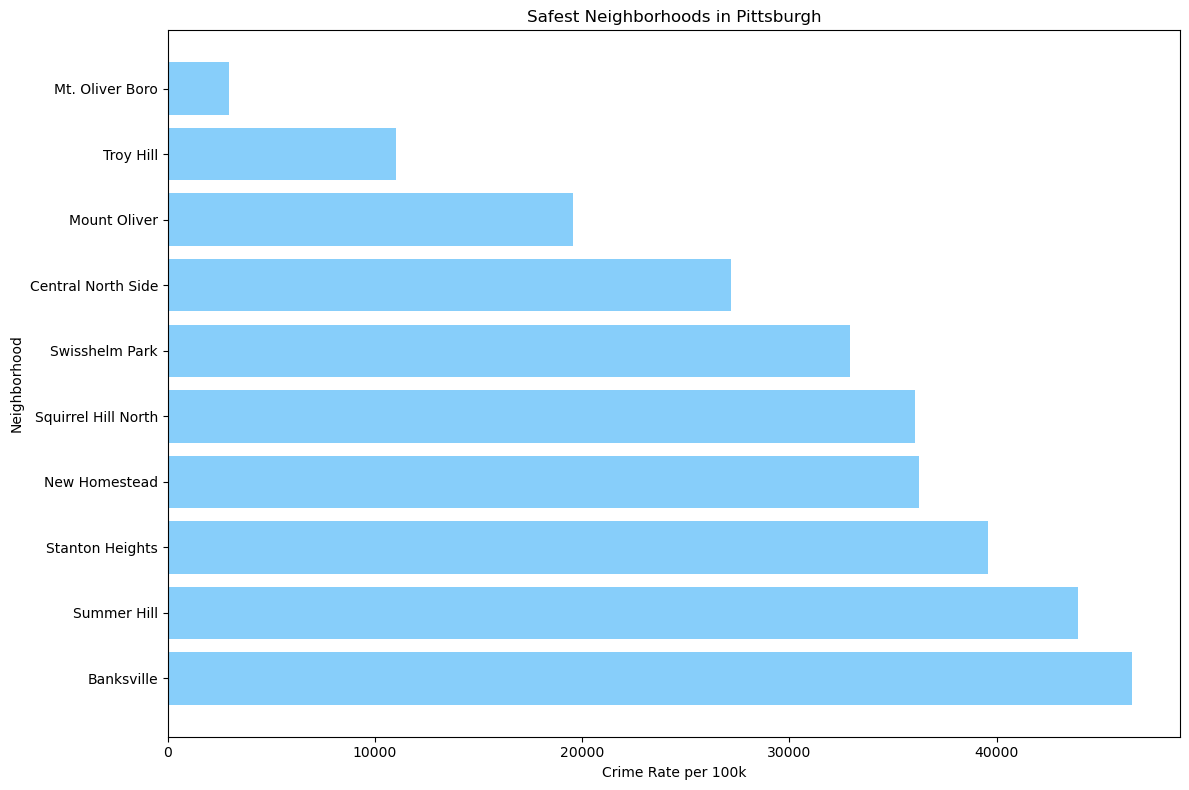

In [32]:
plt.figure(figsize=(12, 8))
top_safe = sorted_data.head(10).sort_values('crime_rate_per_100k', ascending=False)
plt.barh(top_safe['INCIDENTNEIGHBORHOOD'], top_safe['crime_rate_per_100k'], color='LightSkyBlue')

plt.xlabel('Crime Rate per 100k')
plt.ylabel('Neighborhood')
plt.title('Safest Neighborhoods in Pittsburgh')
plt.tight_layout()
plt.show()

## Conclusion
From the analysis, we can see that the safest neighborhoods in Pittsburgh are located in the north side of the city, including Lawrenceville, Highland Park, and North Oakland. These neighborhoods have relatively low crime rates per capita, indicating a relatively safe environment for residents.
The top three safety neighborhoods are Mt. Oliver Boro, Troy Hill and Mount Oliver.

In [33]:
# Export safety score to CSV for final metric
safety_score_export = sorted_data[['INCIDENTNEIGHBORHOOD', 'crime_rate_per_100k']].copy()
safety_score_export.columns = ['neighborhood', 'score']
safety_score_export.to_csv('../Final_Notebook_Data/ruoyu_safety_score.csv', index=False)
